6. Напишите функцию stochastic_gradient_descent, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:

•features - матрица, соответствующая обучающей выборке

•w_init - вектор начальных весов модели

•eta - шаг градиентного спуска (по умолчанию 0.001)

•max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)

•max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу (по умолчанию 1e-8)

•seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)

•verbose - флаг печати информации (например, для отладки, по умолчанию False)

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки.

Функция должна возвращать вектор весов w, а также вектор (список) ошибок, число итераций


In [1]:
import numpy as np
import pickle

from utils import settings, timestamp, YEAR
from utils.arrayview import ArrayView, TimeseriesView


from prediction.models.preprocessing import Model
from prediction.models.prediction import factornames_trimmed
from prediction.models.parameters import factor_build_end

In [2]:
import pandas as pd
import numpy as np
from time import time

In [3]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [4]:
def G_step(df, features, w, b_size, verbose=False):
    """ features = matrix n x i where n = number of the horse, i = feature of the horse
        winer  = vector n where there is only one non zesos in the position winer's horse
        eta = size of the step
        return the step of gradient decent 
    """
    if verbose:
        print 'SG_step'
        print 'shape of data  ',data.shape
        print 
    df['S'] = df.ix[:,features].dot(w)
    df['p'] = df['S'].groupby(by =df['event_id']).apply(softmax)
    df['winer'] = df['result'].apply(lambda x: 1 if x==1 else 0)
    grad = np.dot(df['winer'] -df['p'], df[features])/b_size
    
    return grad 

In [5]:
def G_step_svm(df, features, w, verbose=False):
    """ features = matrix n x i where n = number of the horse, i = feature of the horse
        winer  = vector n where there is only one non zesos in the position winer's horse
        eta = size of the step
        return the step of gradient decent 
    """
    if verbose:
        print 'SG_step'
        print 'shape of data  ',data.shape
        print 
    S = (df.ix[:,features].dot(w)).values
    p = softmax(S)
    winner_mask = (df['result'] ==1).values
    winner = winner_mask.astype(int)
    P_winer = p[winner_mask]
    grad = np.dot(winner -p, df[features])*P_winer/np.power(1-P_winer,2)
    
    return -1*grad 

In [40]:
def G_step_exp_svm(df, features, w, alfa =1, verbose=False):
    """ features = matrix n x i where n = number of the horse, i = feature of the horse
        winer  = vector n where there is only one non zesos in the position winer's horse
        eta = size of the step
        return the step of gradient decent 
    """
    if verbose:
        print 'SG_step'
        print 'shape of data  ',data.shape
        print 
    S = (df.ix[:,features].dot(w)).values
    p = softmax(S)
    winner_mask = (df['result'] ==1).values
    winner = winner_mask.astype(int)
    P_winer = p[winner_mask]
    grad_P = np.dot(winner -p, df[features])*P_winer/np.power(1-P_winer,2)
    marging = np.exp(1- P_winer/(1-P_winer))
    
    return -alfa*np.exp(alfa*(1- P_winer/(1-P_winer)))*grad_P

In [76]:
def stochastic_gradient_descent(data, features,  b_size =150, eta=1e-1, moment = 0.85, la = 0.5,
                                max_iter=250,  min_weight_dist=1e-4, seed=42, verbose=False):
    
    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    
    w = np.random.randn(len(features))
    
    # Счетчик итераций
    iter_num = 0
    # массив изменения градиента
    grad_norm = np.zeros(max_iter+1)
    # значение последнего градиента
    last_grad = np.zeros_like(w)
        
    # Основной цикл
    while (weight_dist > min_weight_dist) and (iter_num < max_iter):
        
        # выберем случайно скачки количеством = b_size
        r_event = np.random.choice(np.unique(data['event_id']), size = b_size)
        
        df = data.ix[np.in1d(data['event_id'], r_event),:]
        #df['S'] = df.ix[:,features].dot(w)
        #df['p'] = df['S'].groupby(by =df['event_id']).apply(softmax)
        #df['WIN'] = df['result'].apply(lambda x: 1 if x==1 else 0)
        #grad = np.dot(df['WIN'] -df['p'], df[features])/b_size
        
        last_grad = moment*last_grad -G_step(df, features, w, b_size) + la *w # градиентный шаг с моментом + регуляризатор
        w = w - eta* last_grad
        
        weight_dist = np.linalg.norm(last_grad, ord=2)
        if (weight_dist <= min_weight_dist):
            print 'SGD covergence'
        
        iter_num +=1
        grad_norm [iter_num]   = weight_dist 
        #weight_dist = grad_norm[-2] +grad_norm[-1]
        if verbose:
            #print 'w  ', w
            print 'iteration', iter_num, 'dist ',weight_dist
        
        #if iter_num > 300:
        #   eta = eta/10.
        #elif iter_num > 600:
        #   eta = eta/10.
        #eta = eta/np.square(iter_num+1) # переменный шаг
         
        if np.any(w == np.nan):
            print "w overcome"
            break
        
    return w, grad_norm , iter_num

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
av = ArrayView.from_file(settings.paths.join('brain_final2cut.av.bcolz'))

In [10]:
tsav = {}
sl = 0
while True:
    try:
        tsav[sl] = ArrayView.from_file(settings.paths.join('brain_final2_slice_%s.av.bcolz' % sl))
    except ValueError:
        break
    sl += 1

In [11]:
mod = Model(av, oos_start=factor_build_end+YEAR)

In [12]:
high_kurtosis_factors =  ['z64f5be67e', 'z90adc182a', 'z7081bf371', 'z34b808e99', 'z757be272e', 'z5a85cd6a9',
                         'zf991b634a', 'z62651f605', 'zd002b7067', 'z2ef7fedca', 'z6f11029f7', 'z412893062',
                          'z919b9585a', 'z89b0eda37', 'z31780b3f4', 'z6631693d3', 'z0b27f29ad', 'zd7cd94e4c', 
                          'zf5b2aef2a']
price_factors = ['zb392bb74a', 'z6809c316d', 'zd678f0538', 'z027f9f0f5', 'z88e79930c', 'z4a72dc02f',
                 'z1a3573928', 'z7b15df227']

In [13]:
%time factors = mod._preprocess_factors(factornames_trimmed, high_kurtosis_factors = high_kurtosis_factors,\
                                        price_factors = price_factors, verbose=True)

INFO:models:Getting factors from av and rescaling...


. . . . .

INFO:models:Filling in missing values...
INFO:models:Computing each factor as linear combination of all the others...


 . . . . .

INFO:models:Number of missing patterns: 7754


 . . . . . . .

INFO:models:Transforming factors by applying CL-model on their Taylor expansions...


 . . . . .CPU times: user 5min 37s, sys: 19.1 s, total: 5min 56s
Wall time: 5min 7s



In [14]:
predict_mask = mod.is1|mod.is2|mod.oos
train_mask = mod.is1|mod.is2
train_event_id = av.event_id[train_mask]
predict_event_id = av.event_id[predict_mask]

In [15]:
import pandas as pd
pd.set_option('display.max_columns', 80)
col_names = ['f{}'.format(i) for i in range(1,58)]
df = pd.DataFrame(data =factors[:, predict_mask].T , columns = col_names)
df['event_id'] = av.event_id[predict_mask]
df['runner_id'] = av.runner_id[predict_mask]
df['result'] = av.result[predict_mask]
df['is1'] = mod.is1[predict_mask]
df['is2'] = mod.is2[predict_mask]
df['oos'] = mod.oos[predict_mask]
df['time'] =av.start_time[predict_mask]
df['obstacle'] = av.obstacle[predict_mask]
df['going'] = av.going[predict_mask]
df['speed'] = av.speed[predict_mask]
df['distance'] = av.distance[predict_mask]
df['prize'] = av.prize[predict_mask]

df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,is1,is2,oos,time,obstacle,going,speed,distance,prize
0,0.066411,1.812371,0.140033,0.007517,-0.000144,0.370123,0.886900,-0.000888,1.492165,-0.504111,0.174814,0.783295,0.478420,0.026520,1.220996,0.317993,-0.000908,-0.000375,0.004848,-0.017851,0.043987,-0.237318,1.049784,-0.046792,-0.006285,0.000628,-0.065017,0.001235,-0.018441,0.274973,-0.487135,0.084544,-0.116107,0.002079,-0.001362,-0.160866,0.091133,0.966224,2.384186e-07,2.492460,0.753668,-0.000403,0.234473,0.250251,0.023256,0.628183,0.098600,-0.014886,-0.089427,0.536910,-0.012463,-0.143313,0.943943,0.417261,-0.000921,-0.000780,0.119300,293661,360456,3,True,True,False,1.443704e+09,F,GD-FM,15.735644,1700.784058,3235.0
1,-0.154959,0.615217,-0.069783,-0.001667,0.001293,0.163312,-0.100933,-0.016348,0.145181,0.085654,0.057041,0.430980,0.132121,0.013572,0.413222,0.189882,-0.016198,-0.002962,0.014569,-0.015469,-0.026517,0.277365,-0.374422,0.029834,0.056561,-0.000221,0.116112,-0.002068,-0.024272,0.090061,-0.030274,-0.498561,0.035182,-0.018710,0.029094,0.031624,-0.061174,0.254454,2.384186e-07,1.648349,0.073634,-0.650115,0.177804,-0.052191,-0.034483,0.370725,-0.247407,-0.023127,0.550295,-0.121513,0.112166,0.040612,0.224962,0.057615,-0.016085,-0.017330,0.026977,293661,375590,5,True,True,False,1.443704e+09,F,GD-FM,15.622030,1700.784058,3235.0
2,0.066411,0.442863,0.069257,0.007517,-0.000144,0.207937,-0.100933,0.014814,-0.010327,-0.566212,0.355908,0.246179,-0.305634,0.031401,0.364949,0.144203,0.014812,0.017871,0.009206,0.012740,-0.014440,0.264392,0.339009,0.039109,-0.006285,0.000204,0.173482,0.001554,0.055569,-0.092425,-0.266650,0.043125,0.001112,0.002079,-0.011063,0.171808,0.014969,0.155725,2.384186e-07,0.941642,0.146075,-0.109316,0.106961,0.005249,0.083641,0.144267,0.098600,0.081410,-0.152771,-0.183572,-0.012463,0.159303,0.488670,0.036059,0.014800,0.014925,0.051179,293661,374610,7,True,True,False,1.443704e+09,F,GD-FM,15.565223,1700.784058,3235.0
3,-0.154959,0.765992,0.129201,-0.025480,-0.000144,0.112316,-0.257098,0.012801,0.304235,0.226926,-0.260937,-0.048408,-0.043558,0.019547,0.549890,-0.284258,0.012796,0.003470,0.009206,0.011642,-0.004117,-0.122674,-0.421721,0.048495,-0.006285,-0.000031,0.239139,0.001421,-0.018441,-0.134330,0.250868,0.486319,0.086636,0.002079,-0.009765,0.190400,0.130183,0.447011,2.384186e-07,0.498932,-0.041847,0.597555,0.001817,-0.037324,-0.019826,-0.163311,-0.247407,-0.014886,0.461782,0.289931,-0.012463,0.088135,-0.126984,-0.495465,0.012784,0.012911,-0.262583,293661,373638,1,True,True,False,1.443704e+09,F,GD-FM,15.849259,1700.784058,3235.0
4,0.066411,0.329832,-0.093768,0.007517,-0.000144,0.112316,0.503109,-0.024129,1.263628,-0.359817,0.086009,-0.048408,-0.043558,0.031450,1.252166,0.158341,-0.024174,-0.019263,0.009206,0.012740,-0.038280,0.105890,0.209527,-0.033071,-0.006285,-0.000099,-0.037533,0.000975,0.097792,0.022945,-0.043148,-0.245328,-0.009627,0.002079,0.011331,-0.122763,-0.217356,1.080508,2.384186e-07,-0.004469,0.049962,0.495737,0.116301,-0.110655,-0.044347,-0.163311,0.098600,0.023900,-0.237007,-0.440662,-0.012463,-0.125458,0.136239,0.442488,-0.024187,-0.024024,0.267151,293661,347906,4,True,True,False,1.443704e+09,F,GD-FM,15.712922,1700.784058,3235.0


In [17]:
features =df.ix[:,'f1':'f57'].columns

In [18]:
%time SGD1 = stochastic_gradient_descent(df.ix[df.is1,:], features, b_size =100, eta = 1e-3, moment = 0.9, verbose=False)

/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying t

CPU times: user 10min 18s, sys: 4.87 s, total: 10min 23s
Wall time: 7min 2s


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

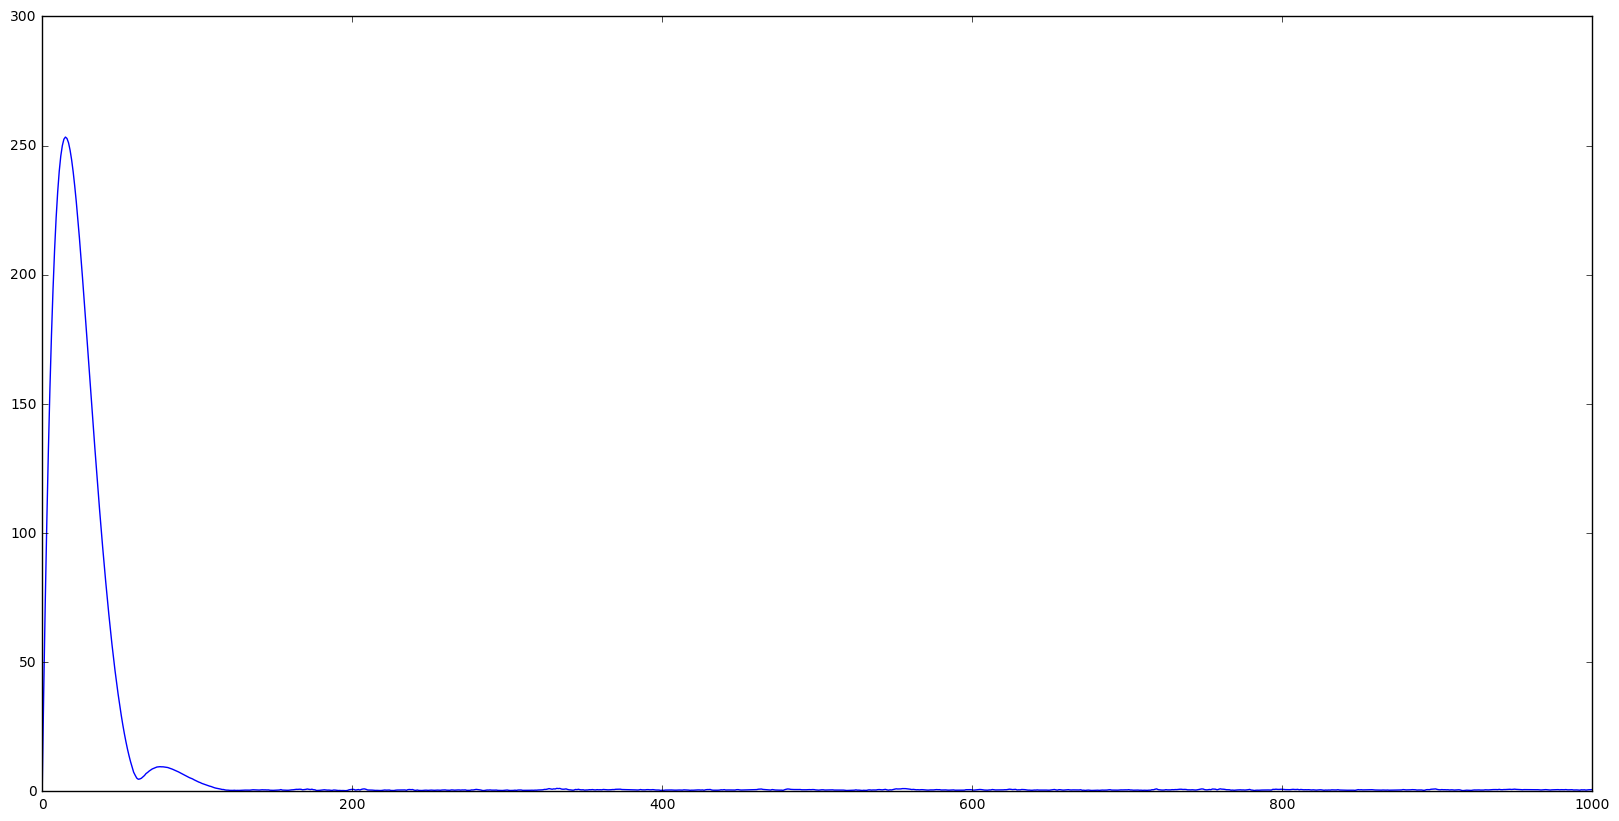

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(SGD1[1])
plt.show()

In [36]:
%time SGD2 = stochastic_gradient_descent(df.ix[df.is1,:], features, b_size =100, eta = 1e-2, moment = 0.85, verbose=False)

/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying t

CPU times: user 10min 23s, sys: 4.5 s, total: 10min 27s
Wall time: 7min 22s


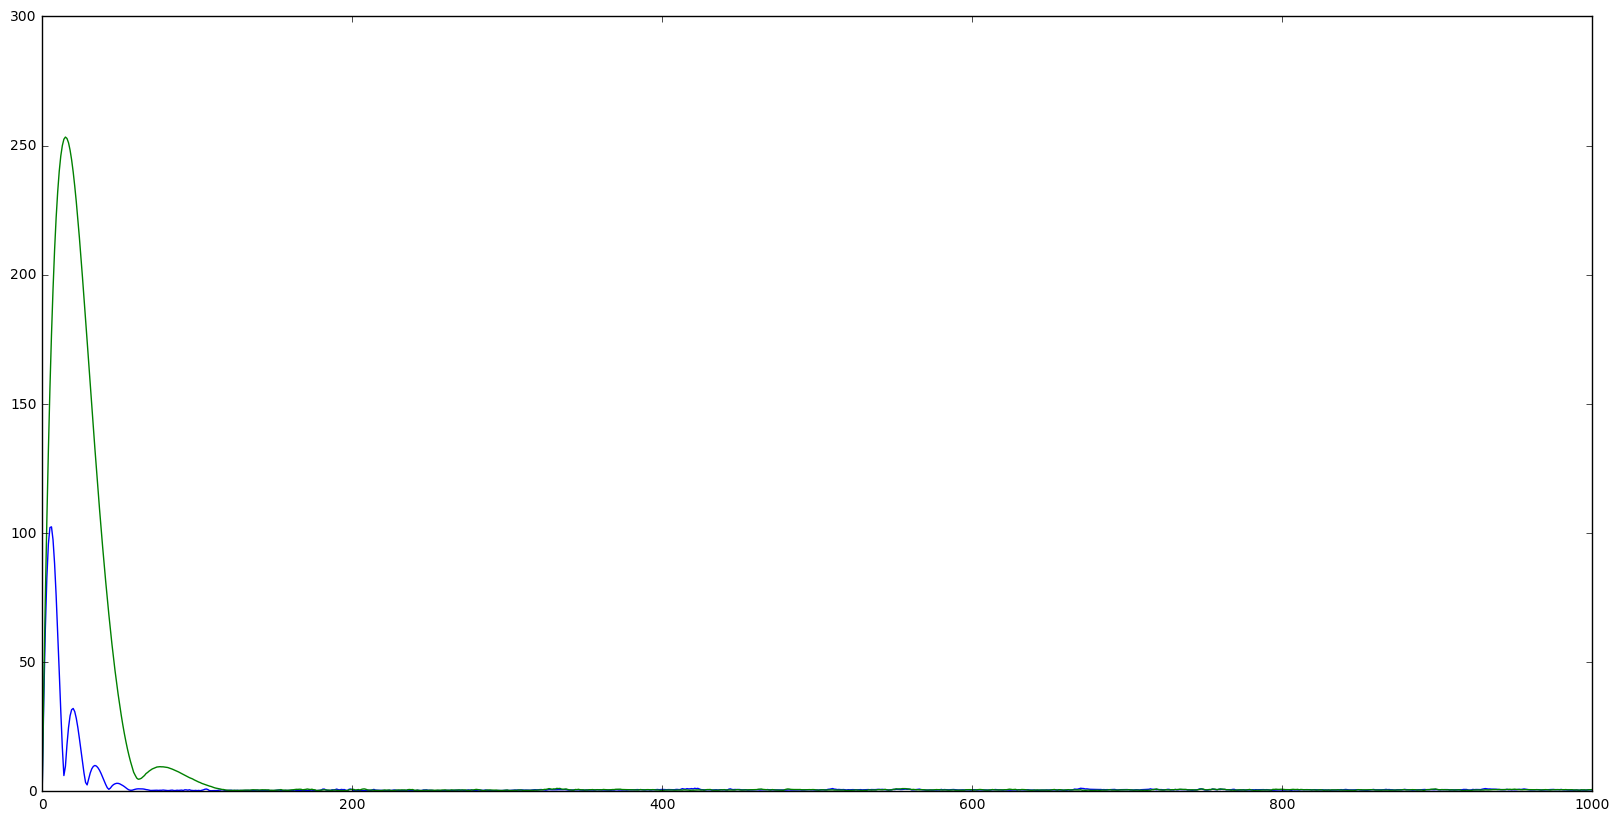

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(SGD2[1])
plt.plot(SGD1[1])
plt.show()

In [38]:
%time SGD3 = stochastic_gradient_descent(df.ix[df.is1,:], features, b_size =100, eta = 1e-1, moment = 0.85, verbose=False)

/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying t

CPU times: user 10min 24s, sys: 4.38 s, total: 10min 29s
Wall time: 7min 31s


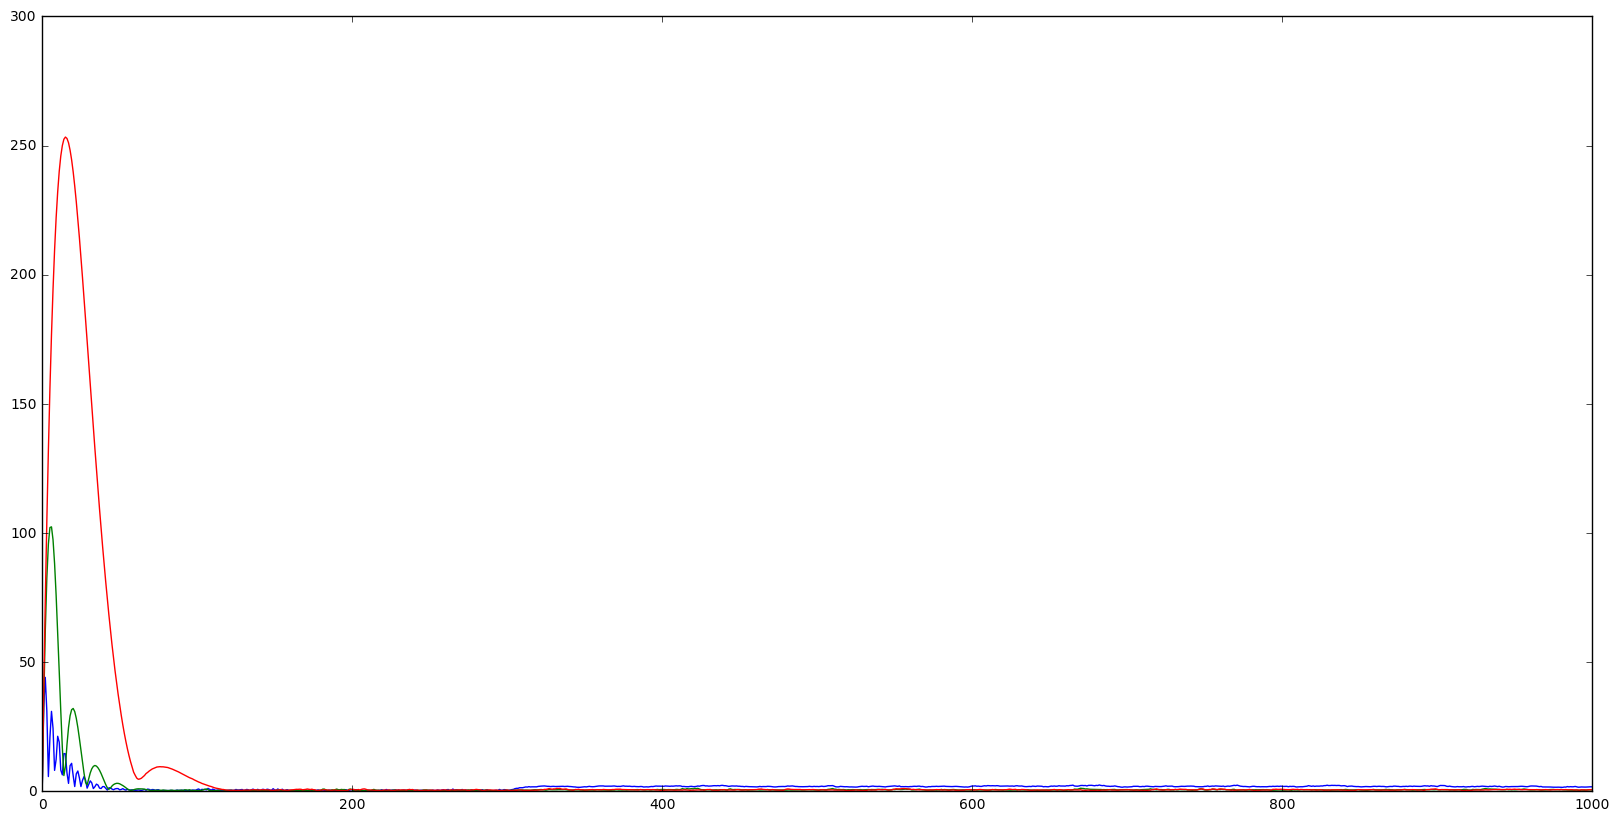

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(SGD3[1])
plt.plot(SGD2[1])
plt.plot(SGD1[1])
plt.show()

In [81]:
%time SGD3 = stochastic_gradient_descent(df.ix[df.is1,:], features, b_size =200, eta = 1e-1, moment = 0.85, la =0.5, max_iter =300, verbose=False)

/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

CPU times: user 5min 49s, sys: 1.47 s, total: 5min 51s
Wall time: 4min 51s


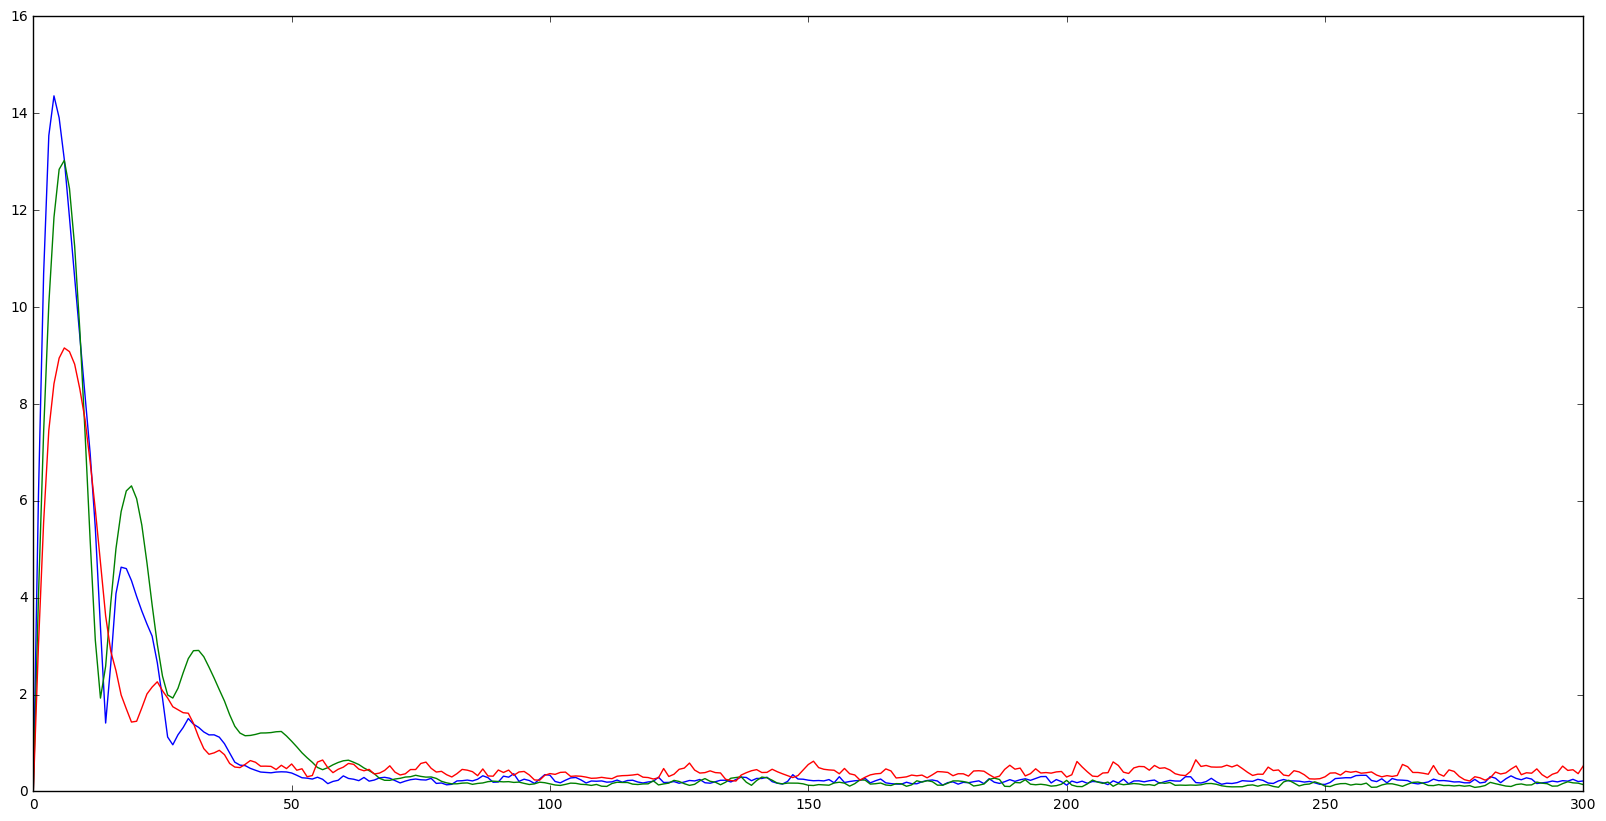

In [82]:
plt.figure(figsize=(20, 10))
plt.plot(SGD2[1])
plt.plot(SGD3[1])
plt.plot(SGD4[1])
plt.show()

In [83]:
W = SGD3[0]
def LL (data, features, w):
    
    S = (data.ix[:,features].dot(w)).values
    P = softmax(S)
    p_winer = P[(data['result']==1).values]
    return np.log(p_winer)

In [88]:
df[df.is1].groupby(by =df['event_id']).apply(lambda x: LL(x, features, W)).mean()

array([-1.96080103])

In [89]:
#w_best, ll_best = W,-2.07263191
for i in range(10):
    
    W1 = np.random.normal(loc =W, scale =0.01, size =(len(features)))
    ll = df[df.is1].groupby(by =df['event_id']).apply(lambda x: LL(x, features, W1)).mean()
    print   ll
    if ll[0] > ll_best:
        w_best = W1
        ll_best = ll[0]

[-1.95734107]
[-1.9622594]
[-1.96273438]
[-1.95773703]
[-1.96144083]
[-1.958595]
[-1.96674767]
[-1.96450757]
[-1.96411785]
[-1.9607095]


In [90]:
SGD3[0][-3:]

array([ 0.01977243,  0.01973803,  0.01629513])

In [94]:
for i in range(10):
    
    W1 = np.random.normal(loc =w_best, scale =0.01, size =(len(features)))
    ll = df[df.is1].groupby(by =df['event_id']).apply(lambda x: LL(x, features, W1)).mean()
    print   ll
    if ll[0] > ll_best:
        w_best = W1
        ll_best = ll[0]

[-1.94064413]
[-1.94069865]
[-1.94055691]
[-1.94043462]
[-1.94074556]
[-1.94085427]
[-1.94077206]
[-1.94080024]
[-1.94130252]
[-1.9406783]


In [96]:
def stochastic_gradient_descent_svm(data, features, W_int =None, b_size =200, eta=1e-1, moment = 0.85, la = 1., alfa =1.,
                                max_iter=300,  min_weight_dist=1e-4, seed=42, verbose=False):
    
    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    w = W_int
    if not w:
        w = np.random.randn(len(features))
    
    # Счетчик итераций
    iter_num = 0
    # массив изменения градиента
    grad_norm = np.zeros(max_iter+1)
    # значение последнего градиента
    last_grad = np.zeros_like(w)
        
    # Основной цикл
    while (weight_dist > min_weight_dist) and (iter_num < max_iter):
        
        # выберем случайно скачки количеством = b_size
        r_event = np.random.choice(np.unique(data['event_id']), size = b_size)
        
        df = data.ix[np.in1d(data['event_id'], r_event),:]
        grad_events = df.groupby(df['event_id']).apply(lambda x: G_step_exp_svm(x, features, w, alfa)).mean()
        #grad_events = df.groupby(df['event_id']).apply(lambda x: G_step_svm_log(x, features, w)).mean()
                                                       
        last_grad = moment*last_grad +grad_events + la *w # градиентный шаг с моментом + регуляризатор
        w = w - eta* last_grad
        
        weight_dist = np.linalg.norm(last_grad, ord=2)
        if (weight_dist <= min_weight_dist):
            print 'SGD covergence'
        
        iter_num +=1
        grad_norm [iter_num]   = weight_dist 
        #weight_dist = grad_norm[-2] +grad_norm[-1]
        if verbose:
            #print 'w  ', w
            print 'iteration', iter_num, 'dist ',weight_dist
        
        #if iter_num > 300:
        #    eta = eta/10.
        #elif iter_num > 600:
        #    eta = eta/10.
        #eta = eta/np.square(iter_num+1) # переменный шаг
         
        if np.any(w == np.nan):
            print "w overcome"
            break
        
    return w, grad_norm , iter_num

In [103]:
%time svm_SGD2 = stochastic_gradient_descent_svm(df[df.is1], features, alfa =1.)

CPU times: user 2min 53s, sys: 20 ms, total: 2min 53s
Wall time: 2min 54s


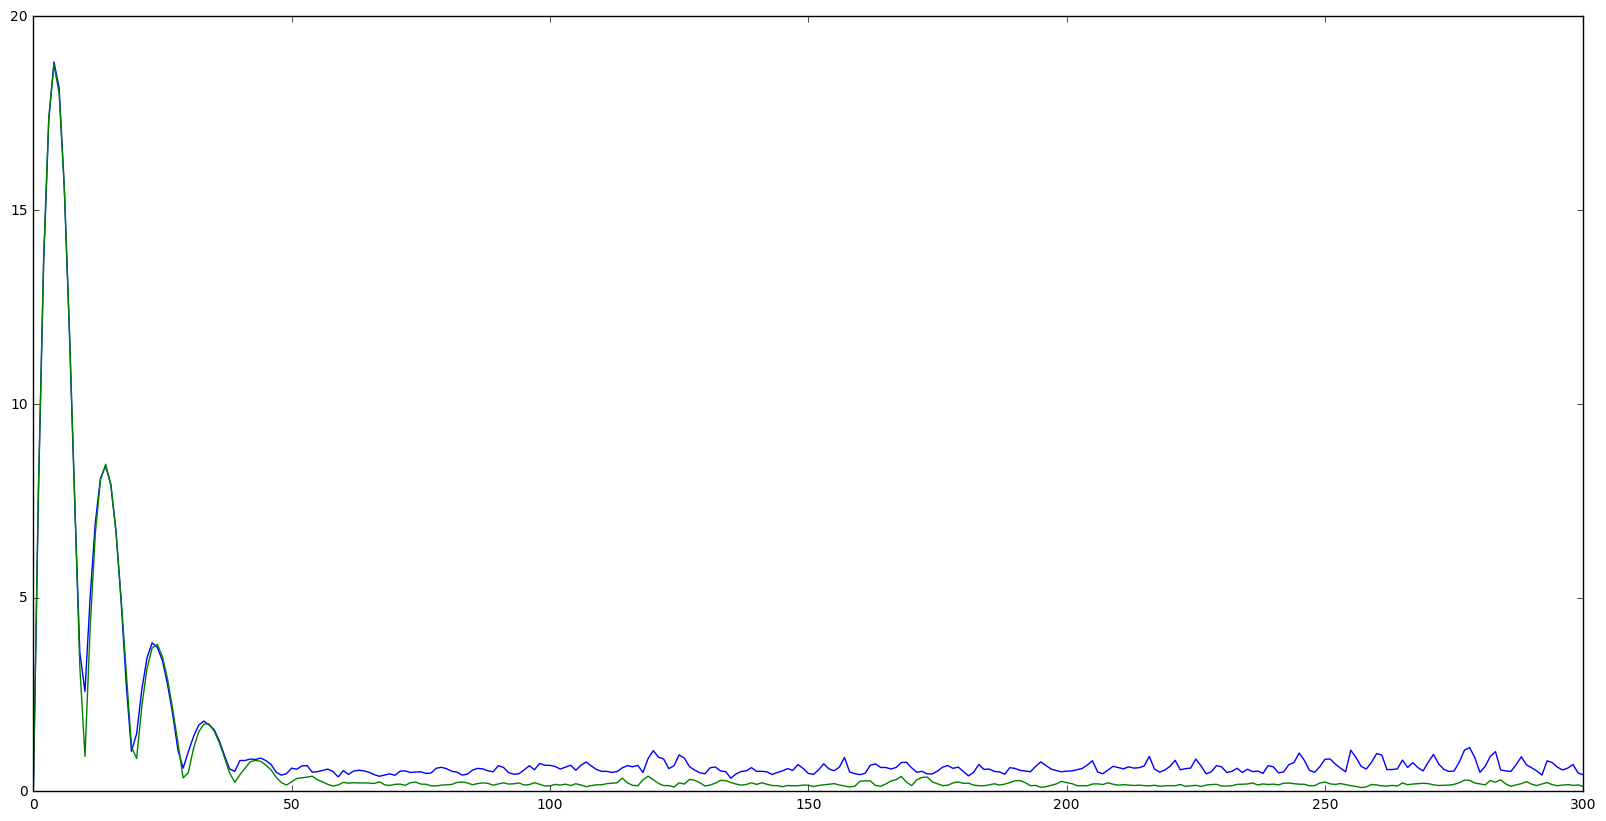

In [104]:
plt.figure(figsize=(20, 10))
plt.plot(svm_SGD2[1])
plt.plot(svm_SGD[1])
plt.show()

In [105]:
W_svm = svm_SGD2[0]
df[df.is1].groupby(by =df['event_id']).apply(lambda x: LL(x, features, W_svm)).mean()

array([-1.98339437])

In [102]:
W_svm = svm_SGD[0]
df[df.is1].groupby(by =df['event_id']).apply(lambda x: LL(x, features, W_svm)).mean()

array([-1.94885848])

In [106]:
W_svm -w_best

array([-0.02013338, -0.02448382,  0.08360542,  0.02784364,  0.0601076 ,
        0.04092603,  0.09260999, -0.04694202,  0.04271556,  0.09869684,
       -0.08285103,  0.12217824,  0.10231264, -0.01046796,  0.10225347,
       -0.04276573, -0.03840256, -0.02641935, -0.11768286,  0.03541488,
       -0.03437407, -0.03443174,  0.04086738,  0.00122649,  0.0188193 ,
       -0.01661987,  0.0089121 , -0.02738525,  0.06514703,  0.00745633,
        0.0133763 ,  0.02952046,  0.03914166, -0.01530935, -0.02222791,
       -0.00214265,  0.02584899,  0.02030742, -0.06000919,  0.0256049 ,
        0.01315259, -0.05906339,  0.10715157,  0.03688038,  0.01627445,
        0.20004438,  0.03789369,  0.03823066, -0.02634859, -0.04673435,
        0.09757255, -0.01897431,  0.08456563,  0.06563165,  0.01714554,
       -0.10497932,  0.07847883])

In [108]:
df['S'] = df[features].dot(W_svm)

In [109]:
df['p'] = df['S'].groupby(by =df['event_id']).apply(softmax)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,is1,is2,oos,time,obstacle,going,speed,distance,prize,S,p
0,0.066411,1.812371,0.140033,0.007517,-0.000144,0.370123,0.886900,-0.000888,1.492165,-0.504111,0.174814,0.783295,0.478420,0.026520,1.220996,0.317993,-0.000908,-0.000375,0.004848,-0.017851,0.043987,-0.237318,1.049784,-0.046792,-0.006285,0.000628,-0.065017,0.001235,-0.018441,0.274973,-0.487135,0.084544,-0.116107,0.002079,-0.001362,-0.160866,0.091133,0.966224,2.384186e-07,2.492460,0.753668,-0.000403,0.234473,0.250251,0.023256,0.628183,0.098600,-0.014886,-0.089427,0.536910,-0.012463,-0.143313,0.943943,0.417261,-0.000921,-0.000780,0.119300,293661,360456,3,True,True,False,1.443704e+09,F,GD-FM,15.735644,1700.784058,3235.0,2.803784,0.578914
1,-0.154959,0.615217,-0.069783,-0.001667,0.001293,0.163312,-0.100933,-0.016348,0.145181,0.085654,0.057041,0.430980,0.132121,0.013572,0.413222,0.189882,-0.016198,-0.002962,0.014569,-0.015469,-0.026517,0.277365,-0.374422,0.029834,0.056561,-0.000221,0.116112,-0.002068,-0.024272,0.090061,-0.030274,-0.498561,0.035182,-0.018710,0.029094,0.031624,-0.061174,0.254454,2.384186e-07,1.648349,0.073634,-0.650115,0.177804,-0.052191,-0.034483,0.370725,-0.247407,-0.023127,0.550295,-0.121513,0.112166,0.040612,0.224962,0.057615,-0.016085,-0.017330,0.026977,293661,375590,5,True,True,False,1.443704e+09,F,GD-FM,15.622030,1700.784058,3235.0,0.969139,0.092435
2,0.066411,0.442863,0.069257,0.007517,-0.000144,0.207937,-0.100933,0.014814,-0.010327,-0.566212,0.355908,0.246179,-0.305634,0.031401,0.364949,0.144203,0.014812,0.017871,0.009206,0.012740,-0.014440,0.264392,0.339009,0.039109,-0.006285,0.000204,0.173482,0.001554,0.055569,-0.092425,-0.266650,0.043125,0.001112,0.002079,-0.011063,0.171808,0.014969,0.155725,2.384186e-07,0.941642,0.146075,-0.109316,0.106961,0.005249,0.083641,0.144267,0.098600,0.081410,-0.152771,-0.183572,-0.012463,0.159303,0.488670,0.036059,0.014800,0.014925,0.051179,293661,374610,7,True,True,False,1.443704e+09,F,GD-FM,15.565223,1700.784058,3235.0,0.683673,0.069480
3,-0.154959,0.765992,0.129201,-0.025480,-0.000144,0.112316,-0.257098,0.012801,0.304235,0.226926,-0.260937,-0.048408,-0.043558,0.019547,0.549890,-0.284258,0.012796,0.003470,0.009206,0.011642,-0.004117,-0.122674,-0.421721,0.048495,-0.006285,-0.000031,0.239139,0.001421,-0.018441,-0.134330,0.250868,0.486319,0.086636,0.002079,-0.009765,0.190400,0.130183,0.447011,2.384186e-07,0.498932,-0.041847,0.597555,0.001817,-0.037324,-0.019826,-0.163311,-0.247407,-0.014886,0.461782,0.289931,-0.012463,0.088135,-0.126984,-0.495465,0.012784,0.012911,-0.262583,293661,373638,1,True,True,False,1.443704e+09,F,GD-FM,15.849259,1700.784058,3235.0,0.532899,0.059756
4,0.066411,0.329832,-0.093768,0.007517,-0.000144,0.112316,0.503109,-0.024129,1.263628,-0.359817,0.086009,-0.048408,-0.043558,0.031450,1.252166,0.158341,-0.024174,-0.019263,0.009206,0.012740,-0.038280,0.105890,0.209527,-0.033071,-0.006285,-0.000099,-0.037533,0.000975,0.097792,0.022945,-0.043148,-0.245328,-0.009627,0.002079,0.011331,-0.122763,-0.217356,1.080508,2.384186e-07,-0.004469,0.049962,0.495737,0.116301,-0.110655,-0.044347,-0.163311,0.098600,0.023900,-0.237007,-0.440662,-0.012463,-0.125458,0.136239,0.442488,-0.024187,-0.024024,0.267151,293661,347906,4,True,True,False,1.443704e+09,F,GD-FM,15.712922,1700.784058,3235.0,0.820340,0.079655


In [110]:
df['1_p'] = 1- df['p']
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,is1,is2,oos,time,obstacle,going,speed,distance,prize,S,p,1_p
0,0.066411,1.812371,0.140033,0.007517,-0.000144,0.370123,0.886900,-0.000888,1.492165,-0.504111,0.174814,0.783295,0.478420,0.026520,1.220996,0.317993,-0.000908,-0.000375,0.004848,-0.017851,0.043987,-0.237318,1.049784,-0.046792,-0.006285,0.000628,-0.065017,0.001235,-0.018441,0.274973,-0.487135,0.084544,-0.116107,0.002079,-0.001362,-0.160866,0.091133,0.966224,2.384186e-07,2.492460,0.753668,-0.000403,0.234473,0.250251,0.023256,0.628183,0.098600,-0.014886,-0.089427,0.536910,-0.012463,-0.143313,0.943943,0.417261,-0.000921,-0.000780,0.119300,293661,360456,3,True,True,False,1.443704e+09,F,GD-FM,15.735644,1700.784058,3235.0,2.803784,0.578914,0.421086
1,-0.154959,0.615217,-0.069783,-0.001667,0.001293,0.163312,-0.100933,-0.016348,0.145181,0.085654,0.057041,0.430980,0.132121,0.013572,0.413222,0.189882,-0.016198,-0.002962,0.014569,-0.015469,-0.026517,0.277365,-0.374422,0.029834,0.056561,-0.000221,0.116112,-0.002068,-0.024272,0.090061,-0.030274,-0.498561,0.035182,-0.018710,0.029094,0.031624,-0.061174,0.254454,2.384186e-07,1.648349,0.073634,-0.650115,0.177804,-0.052191,-0.034483,0.370725,-0.247407,-0.023127,0.550295,-0.121513,0.112166,0.040612,0.224962,0.057615,-0.016085,-0.017330,0.026977,293661,375590,5,True,True,False,1.443704e+09,F,GD-FM,15.622030,1700.784058,3235.0,0.969139,0.092435,0.907565
2,0.066411,0.442863,0.069257,0.007517,-0.000144,0.207937,-0.100933,0.014814,-0.010327,-0.566212,0.355908,0.246179,-0.305634,0.031401,0.364949,0.144203,0.014812,0.017871,0.009206,0.012740,-0.014440,0.264392,0.339009,0.039109,-0.006285,0.000204,0.173482,0.001554,0.055569,-0.092425,-0.266650,0.043125,0.001112,0.002079,-0.011063,0.171808,0.014969,0.155725,2.384186e-07,0.941642,0.146075,-0.109316,0.106961,0.005249,0.083641,0.144267,0.098600,0.081410,-0.152771,-0.183572,-0.012463,0.159303,0.488670,0.036059,0.014800,0.014925,0.051179,293661,374610,7,True,True,False,1.443704e+09,F,GD-FM,15.565223,1700.784058,3235.0,0.683673,0.069480,0.930520
3,-0.154959,0.765992,0.129201,-0.025480,-0.000144,0.112316,-0.257098,0.012801,0.304235,0.226926,-0.260937,-0.048408,-0.043558,0.019547,0.549890,-0.284258,0.012796,0.003470,0.009206,0.011642,-0.004117,-0.122674,-0.421721,0.048495,-0.006285,-0.000031,0.239139,0.001421,-0.018441,-0.134330,0.250868,0.486319,0.086636,0.002079,-0.009765,0.190400,0.130183,0.447011,2.384186e-07,0.498932,-0.041847,0.597555,0.001817,-0.037324,-0.019826,-0.163311,-0.247407,-0.014886,0.461782,0.289931,-0.012463,0.088135,-0.126984,-0.495465,0.012784,0.012911,-0.262583,293661,373638,1,True,True,False,1.443704e+09,F,GD-FM,15.849259,1700.784058,3235.0,0.532899,0.059756,0.940244
4,0.066411,0.329832,-0.093768,0.007517,-0.000144,0.112316,0.503109,-0.024129,1.263628,-0.359817,0.086009,-0.048408,-0.043558,0.031450,1.252166,0.158341,-0.024174,-0.019263,0.009206,0.012740,-0.038280,0.105890,0.209527,-0.033071,-0.006285,-0.000099,-0.037533,0.000975,0.097792,0.022945,-0.043148,-0.245328,-0.009627,0.002079,0.011331,-0.122763,-0.217356,1.080508,2.384186e-07,-0.004469,0.049962,0.495737,0.116301,-0.110655,-0.044347,-0.163311,0.098600,0.023900,-0.237007,-0.440662,-0.012463,-0.125458,0.136239,0.442488,-0.024187,-0.024024,0.267151,293661,347906,4,True,True,False,1.443704e+09,F,GD-FM,15.712922,1700.784058,3235.0,0.820340,0.079655,0.920345


In [120]:
df['log_dis'] =np.log(df['p']/df['1_p']) 

In [117]:
def new_factors_array (X, predict_mask =predict_mask):
    
    
    factors_new = np.zeros((X.shape[1], predict_mask.shape[0]))

    j=0
    for i,flag in enumerate(predict_mask):
        if flag:
            factors_new[:,i] = X[j,:]
            j +=1
    return factors_new

In [121]:
factors_new = np.vstack((factors,new_factors_array(df[['p','1_p','log_dis']].values)))
factors_new.shape

(60, 1631851)

In [122]:
model_coefs, model_step1prob, model_step2prob, model_likelihood \
= mod.fit_slices(tsav, factors_new, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print "LL new factors model"
print model_likelihood
print 


old_coefs, old_step1prob, old_step2prob, old_likelihood \
= mod.fit_slices(tsav, factors, depth=3, lmbd=10, verbose=False, fit_afresh=True)
print "LL old model"
print old_likelihood

. . . . . . . . . . 10
LL new factors model
[[-1809.61206335 -1996.91037055 -1996.91037055]
 [-1815.30463699 -1993.19236281 -1993.19236281]
 [-1820.47390157 -1990.82818713 -1990.82818713]
 [-1825.052017   -1978.4184152  -1978.4184152 ]
 [-1845.35910748 -1956.65357323 -1956.65357323]
 [-1863.08161038 -1951.50262067 -1951.50262067]
 [-1903.75454614 -1924.30055348 -1924.30055348]
 [-1921.14237209 -1902.67836294 -1902.67836294]
 [-1923.9099056  -1902.61461223 -1902.61461223]
 [-1928.92206705 -1895.43362563 -1895.43362563]
 [    0.             0.             0.        ]]

. . . . . . . . . . 10
LL old model
[[-1809.60545794 -1997.12919856 -1997.12919856]
 [-1815.29560313 -1993.38729693 -1993.38729693]
 [-1820.46573311 -1991.13279316 -1991.13279316]
 [-1825.04841809 -1978.8072344  -1978.8072344 ]
 [-1845.34679456 -1957.00310184 -1957.00310184]
 [-1863.07407698 -1951.28943929 -1951.28943929]
 [-1903.75005795 -1924.17873405 -1924.17873405]
 [-1921.12493591 -1902.65155685 -1902.65155685]
 [-192

In [123]:
def dic_to_tenzor(dic, key, base):
    '''
    tenzor where first dimention is the number of cluster
    0 = no_cluster
    <dic> dictionary cluster's data that to convert in tenzor
    <key> the list of clusters that use 
    <base> no cluster data
    '''
    
    key_0 = dic.keys()[0]
    tenzor = np.zeros((len(key)+1, dic[key_0].shape[0], dic[key_0].shape[1]))
    try:
        tenzor[0,:,:] = base
    except:
        print 'base and dic[k] have the diferent size'
        return
    for i,k in enumerate(key):
        tenzor[i+1,:,:] = dic[k]
    return tenzor

In [124]:
def write_dic_to_simdata(file_name, old_step1probs, old_coefs, oos, data=None, av =av,
                         cluster_step1probs =None, cluster_coefs =None, cluster_names =None):
    """
    <file_name> is name of file to record
    <old_step1probs> is expected to be a matrix N_slices x len(av)
    <old_coefs> is a coefficient matrix with the size N_slices x 3
    <oos> is a boolean mask denoting the out of sample range. len(oos) shoud equal len(av)
    <data>  pandas Series index = event_id, data = cluster's names
    <cluster_step1probs> is expected to be a dictionary: key is the cluster name and
                        data are the matrix N_slices x len(av) for each cluster
    <cluster_coefs> is a dictionary : key is the cluster name and data and 
                        data are the coefficient matrix with the size N_slices x 3
    <cluster_number> is an integer array with the cluster numbers per race. Size: len(av)
    """
    
    cl_number= np.zeros((len(av.event_id)))
    
    if cluster_names is not None:
        
        s1prob = dic_to_tenzor(cluster_step1probs, cluster_names, old_step1probs)
        coef_s = dic_to_tenzor(cluster_coefs, cluster_names, old_coefs)
        
        for i,k in enumerate(cluster_names):
            mask = np.in1d(av.event_id,data.index[data ==k])
            cl_number = np.where(mask, i+1, cl_number)
        #cl_number = clusters_number(data, cluster_names, av=av)
          
        
    else:
        
        s1prob = np.zeros((1,old_step1probs.shape[0], old_step1probs.shape[1]))
        s1prob[0,:,:] = old_step1probs
        coef_s = np.zeros((1,old_coefs.shape[0], old_coefs.shape[1]))
        coef_s[0,:,:] = old_coefs
        
        

    #write_simdata(s1prob, oos, coef_s, cl_number, file_ = file_name)
    s1prob = s1prob[:,:,oos]
    cl_number = cl_number[oos]
    
    with open (settings.paths.join(file_name), 'wb') as f:
            pickle.dump( [s1prob, oos, coef_s, cl_number], f)
    return

In [125]:
write_dic_to_simdata('simdata_plusSVM', model_step1prob, model_coefs, mod.oos)

In [126]:
model_step1prob.shape

(11, 1631851)